## Convolutional Neural Networks
We'll then learn about the inner workings of convolutional neural networks (CNNs) by using a toy example before understanding some of their major hyperparameters, including strides, pooling, and filters. Next, we will leverage CNNs, along with various data augmentation techniques, to solve the issue of traditional deep neural networks not having good accuracy. Following this, we will learn about what the outcome of a feature learning process in a CNN looks like. Finally, we'll put our learning together to solve a use case: we'll be classifying an image by stating whether the image contains a dog or a cat.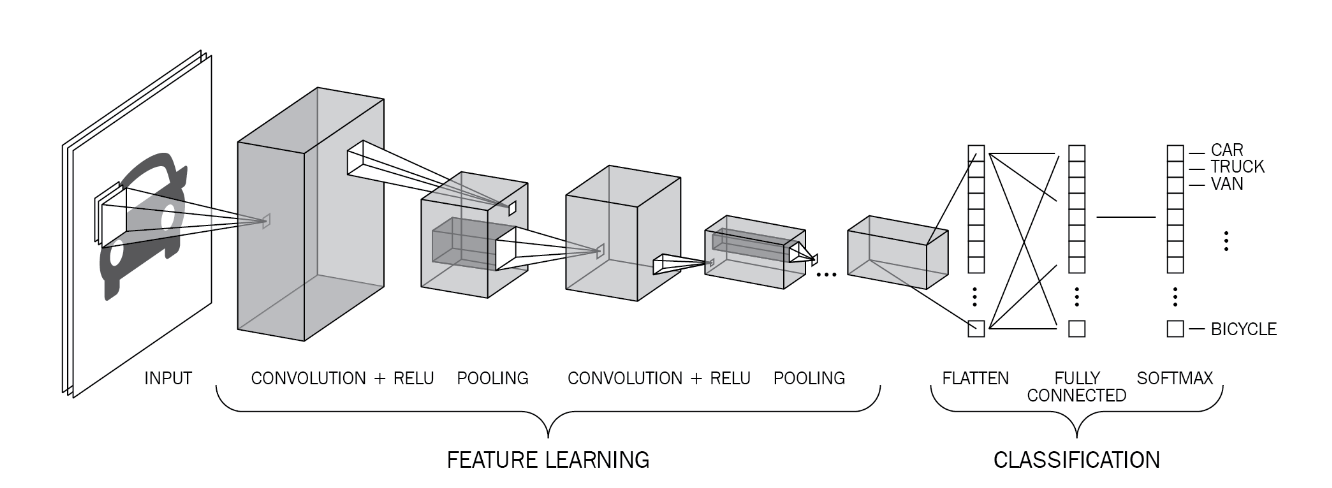

In [ ]:
from torchvision import datasets
import torch
data_folder = '/content/' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11747123.20it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210248.03it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3906899.09it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6247765.33it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [ ]:
tr_images = fmnist.data
tr_targets = fmnist.targets

val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Pass the image through the trained model

In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [ ]:
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


Text(0.5, 1.0, 'Trouser')

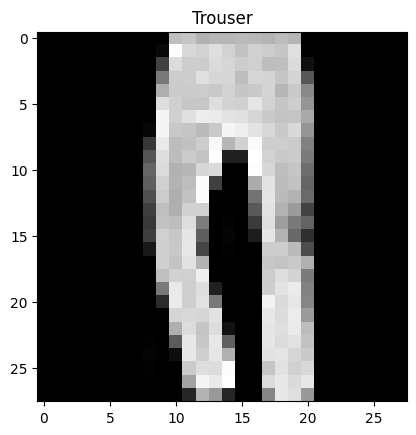

In [ ]:
#ix = np.random.randint(len(tr_images))
ix = 24300
plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])

In [ ]:
img = tr_images[ix]/255.
img = img.view(28*28)
img = img.to(device)

np_output = model(img).cpu().detach().numpy()
np.exp(np_output)/np.sum(np.exp(np_output))

array([1.6074063e-06, 9.9999845e-01, 1.5951922e-10, 2.4083020e-08,
       7.1593962e-09, 2.2673081e-15, 4.1916781e-09, 3.6594267e-24,
       3.3281666e-11, 2.8583885e-15], dtype=float32)

Translation

In [ ]:
tr_targets[ix]

tensor(1)

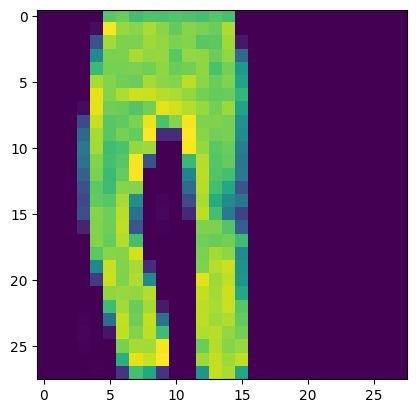

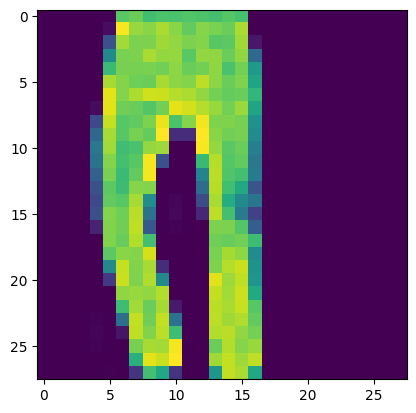

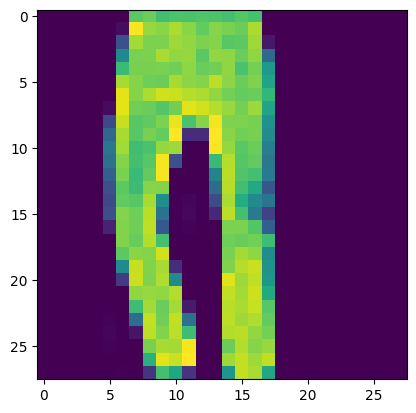

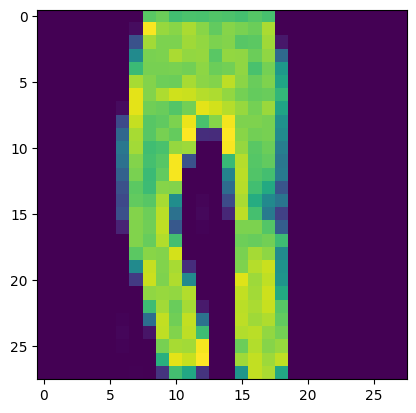

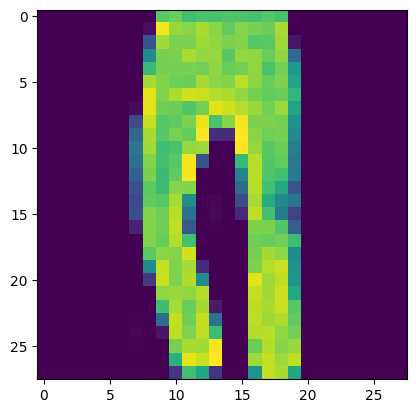

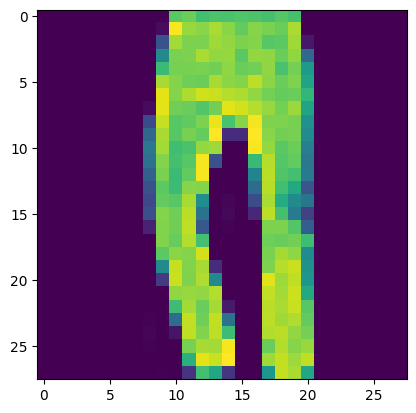

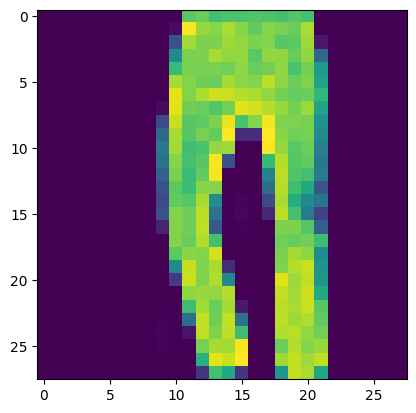

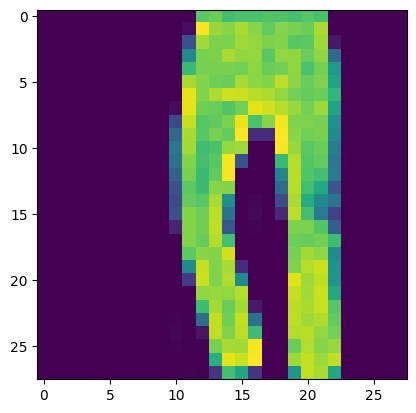

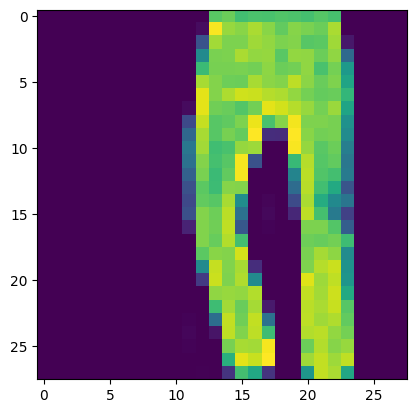

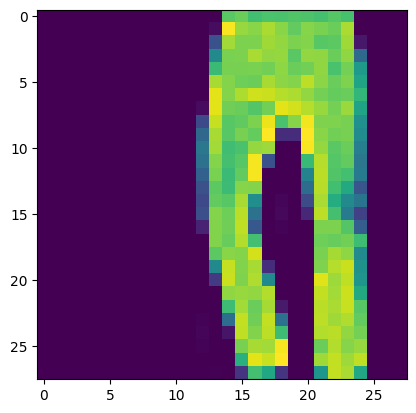

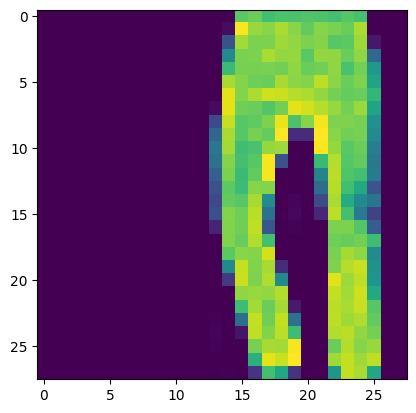

In [ ]:
preds = []
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  #img2 = np.zeros((28,28))
  img2 = np.roll(img, px, axis=1)
  plt.imshow(img2)
  plt.show()
  img3 = torch.Tensor(img2).view(28*28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

<Axes: title={'center': 'Probability of each class for various translations'}>

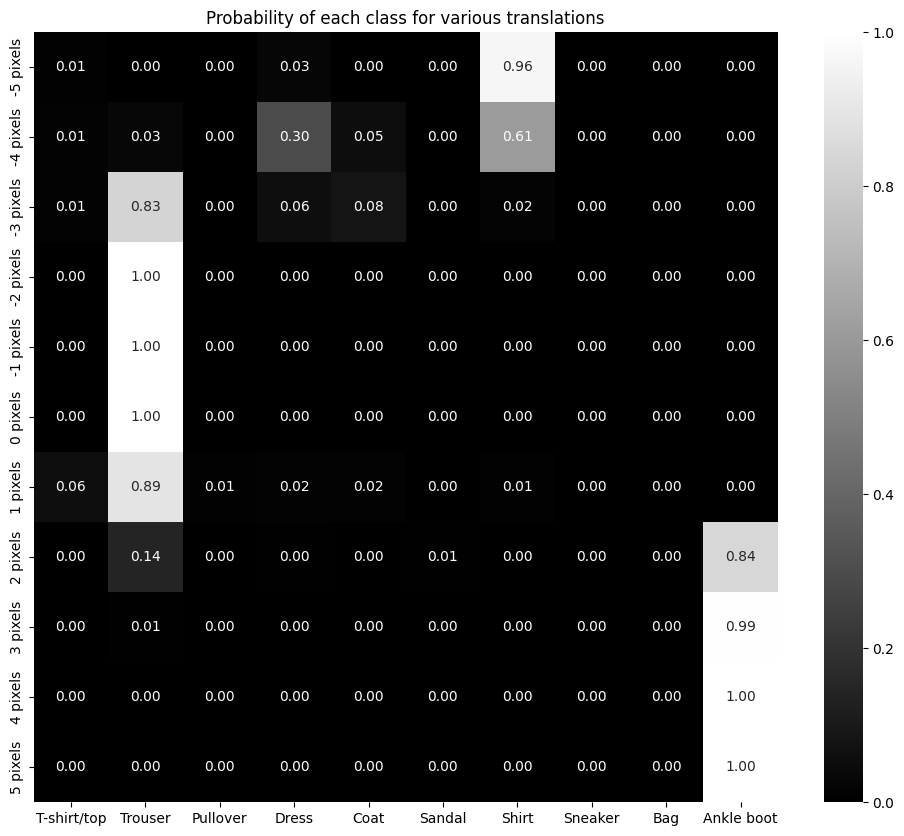

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')

Now that we have learned about a scenario where a traditional neural network fails, we will learn about how CNNs help address this problem. But before we do this, we will learn about the building blocks of a CNN.

## Building blocks of a CNN
CNNs are the most prominent architectures that are used when working on images. Besides image classification, they also help with object detection, image segmentation, GANs, and many more – essentially, wherever we use images. Furthermore, there are different ways of constructing a convolutional neural network, and there are multiple pre-trained models that leverage CNNs to perform various tasks.

we will understand the fundamental building blocks of a CNN, which are as follows:

- Convolutions
- Filters
- Strides and padding
- Pooling

1. Convolutions:
In essence, convolution involves the multiplication of two matrices: a smaller matrix (often termed a filter or kernel) sliding over a larger matrix (the original image). This process entails element-wise multiplication of corresponding elements from the matrices at each position and summing the products. The result forms a new matrix that captures the combined information from these multiplications. In the context of neural networks, this operation is fundamental, akin to matrix multiplication used in training.

2. Filters:

Filters in neural networks begin with randomly initialized weight matrices, refined over training epochs to learn image features. More filters in a CNN enable the model to capture diverse aspects of an image. Each filter learns distinct features, like identifying specific parts of an image, such as cat ears. Convolution with multiple filters produces multiple output matrices, each representing different learned features. The output dimensions align with the number of filters used, impacting the depth and channels of the resulting convolutions.

3. Strides and padding
Filter striding reduces the output size by 1 pixel in both height and width compared to the input image, potentially impacting information retention and the possibility of residual addition

3 a) Strides:
Using the same example from the Filter section, when striding Matrix B with a value of 2 over Matrix A, the resulting output of the convolution is smaller in dimensions compared to a stride of 1, as the output shape is reduced due to the stride of 2.

3 b) Padding
Padding adds zeros to the image edges, enabling complete element-wise multiplication with a filter, preventing dimension reduction during convolution. It's particularly useful in scenarios like residual networks where adding convolution output to the original image is required without changing dimensions.

4. Pooling
Pooling aggregates information within defined patches (e.g., max pooling selects the maximum value).Reduces matrix size significantly; for example, a 4x4 matrix can shrink to 2x2, and in practical scenarios, a 200x200 image can be reduced to 99x99 after convolution and pooling.Max pooling is a common choice among pooling methods for its effectiveness in retaining key information.

<strong>Putting All Together</strong>:
CNNs use convolution, filters, and pooling to condense image dimensions for feature learning. The flatten layer compresses pooled data, resembling an input layer, which then passes through hidden layers for class prediction. This process involves convolving an image, applying filters, and pooling, followed by flattening for efficient computation, reducing parameters significantly.


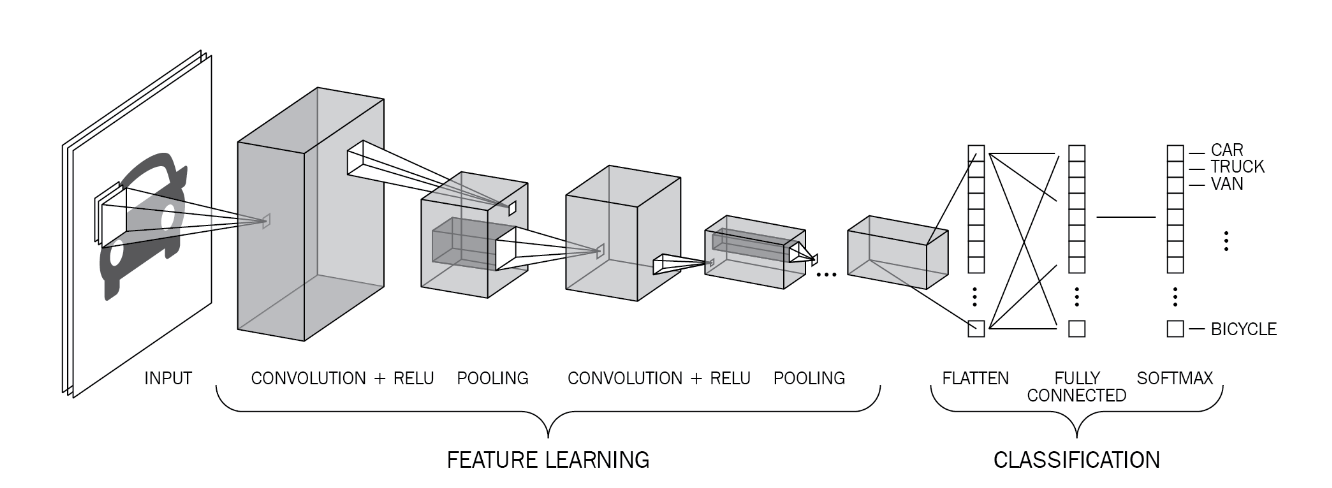

Pooling abstracts regions of an image, aiding in tasks like image translation. When an image is shifted by 1 pixel and subjected to convolution, activation, and pooling, the pooled image, containing reduced dimensions, preserves key information due to region-based pooling. Even with a translation, the information within a pixel of the pooled image remains constant as the maximum value of that region likely persists.

Convolution and pooling contribute to receptive fields in CNNs. For instance, after two convolution-pooling cycles on a 100x100 image, resulting in a 25x25 output, each cell in this output represents a larger 4x4 portion of the original image. This process enables each cell in the output to correspond to a patch of the initial image.

Understanding these core CNN components sets the stage for applying them together in a practical example.








## Building a CNN-based architecture using PyTorch

In [14]:
from torchvision import datasets
import torch
data_folder = '/content/' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)



tr_images = fmnist.data
tr_targets = fmnist.targets

val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [17]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl


@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [18]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [19]:

!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

In [20]:

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


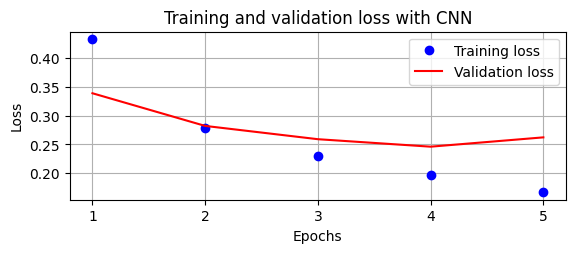

<ipython-input-21-7a9e3eea833f>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


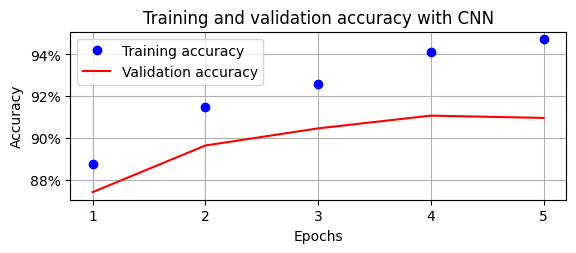

In [21]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

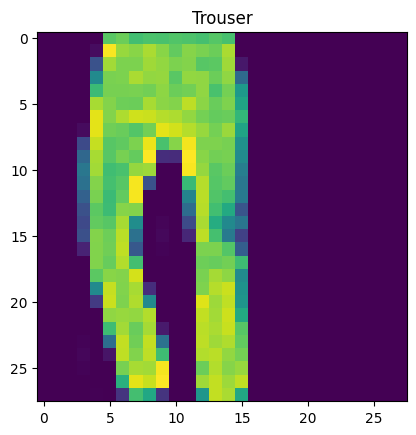

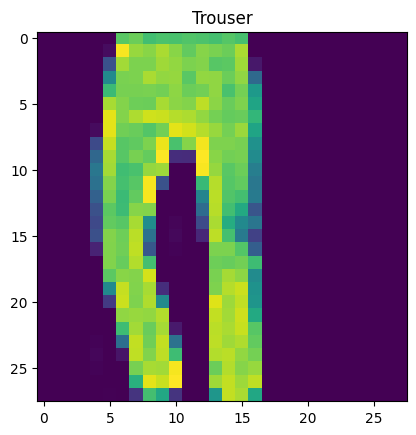

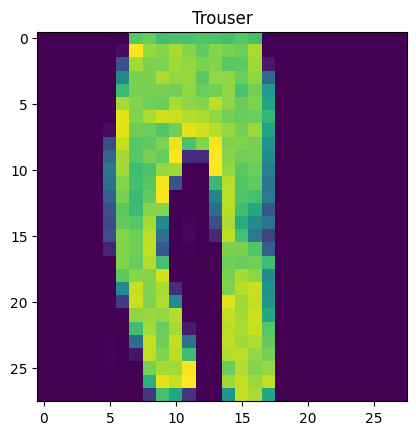

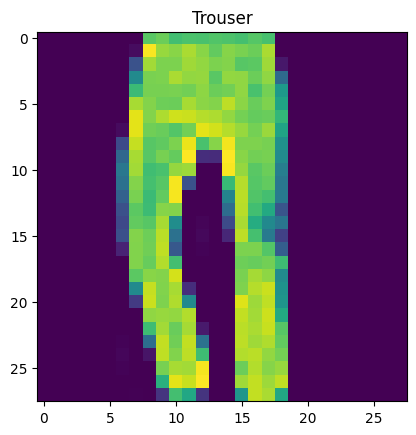

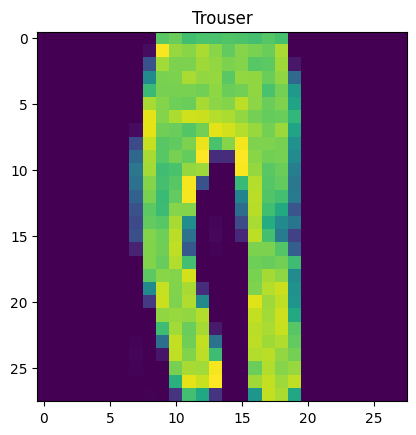

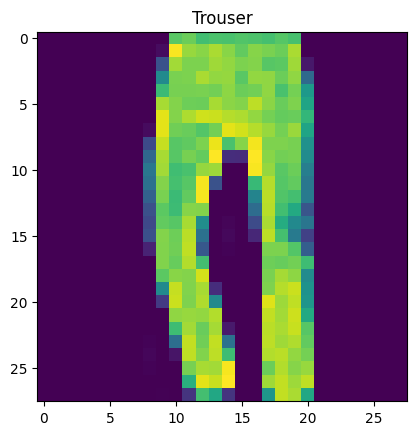

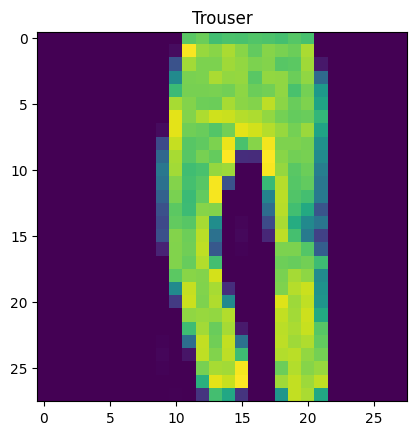

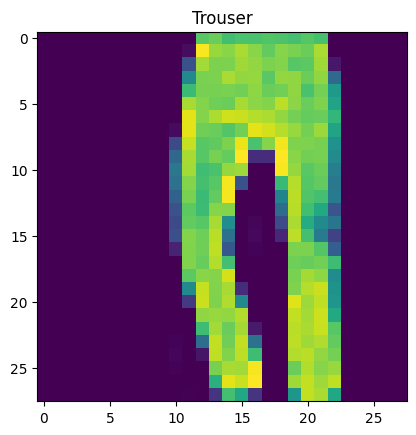

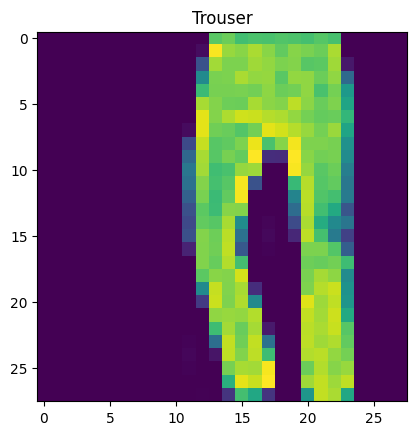

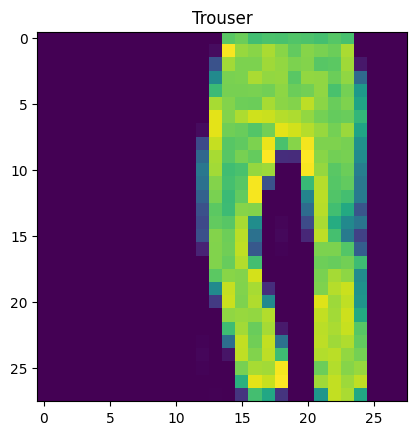

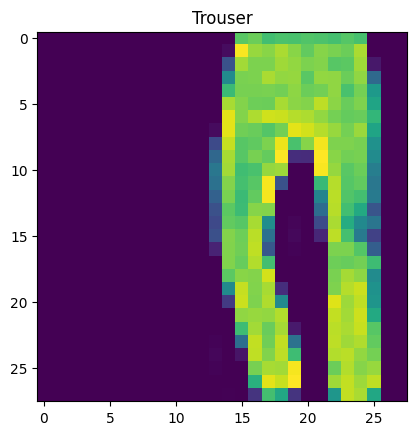

In [22]:
preds = []
ix = 24300
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  img2 = np.roll(img, px, axis=1)
  img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  pred = np.exp(np_output)/np.sum(np.exp(np_output))
  preds.append(pred)
  plt.imshow(img2)
  plt.title(fmnist.classes[pred[0].argmax()])
  plt.show()

<Axes: title={'center': 'Probability of each class for various translations'}>

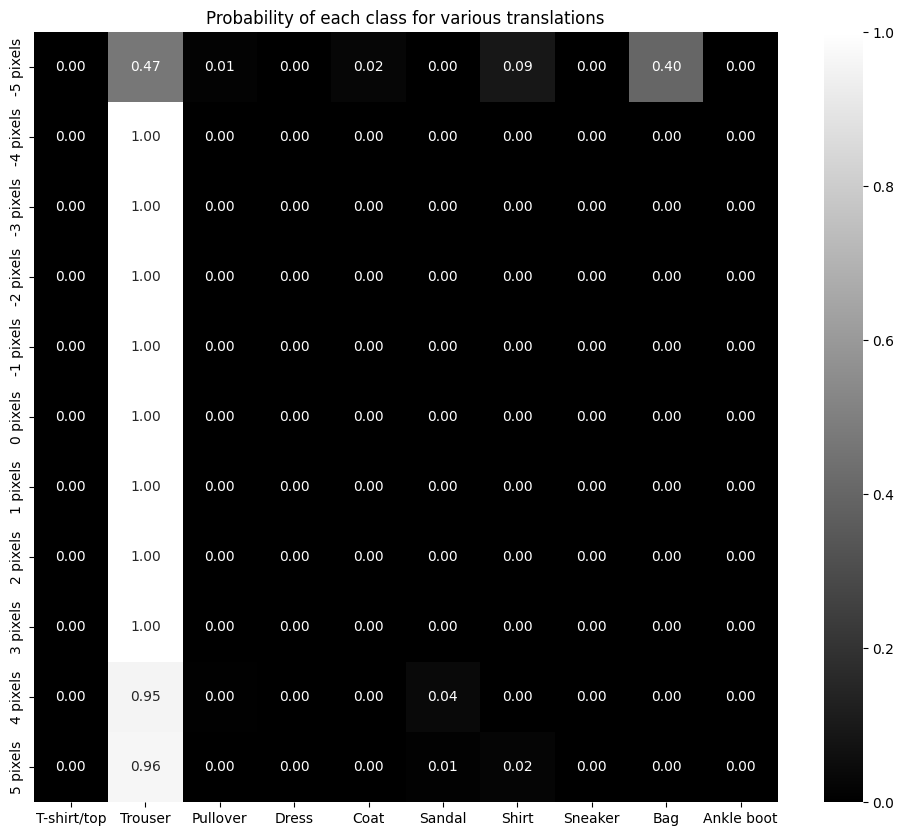

In [23]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')